# Machine learning DTI talk
*Rob Chavez - September 18th, 2018*

The code below was used to generate the analyses for my talk at the University of Oregon Machine Learning Symposium. 

In [124]:
%matplotlib inline
from nltools.data import Brain_Data

from nilearn import plotting, image, input_data, datasets
import numpy as np
import pandas as pd
import os
import nltools as nlt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from nltools.plotting import plotBrain


# Load data

In [125]:
# load behavior and assign subject ID
os.chdir("/Users/rchavez/Desktop/dartmouth/stats/")
behav = pd.read_csv('../FA/behavioral_data.csv')
behav['SubjectID'] = np.arange(1,49)

# create split-half data partition
behav['Holdout'] = ['train','test'] * 24 

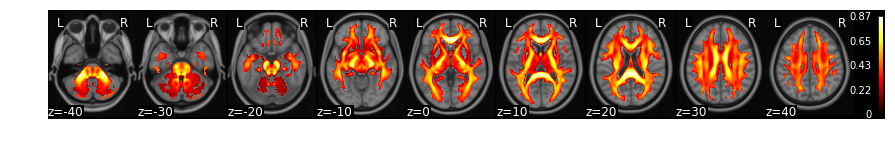

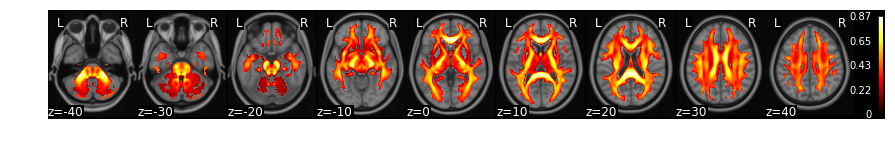

In [126]:
# Load FA data
fa_data = Brain_Data('../FA/origdata/ANTs/all_ants_FA.nii.gz', mask = '../FA/origdata/ANTs/ants_FA_thrSNR_mask.nii.gz', X = behav)
fa_data.mean().plot()

# Fit models

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 16.19
overall CV Correlation: 0.08


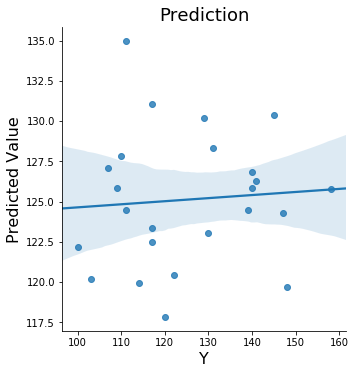

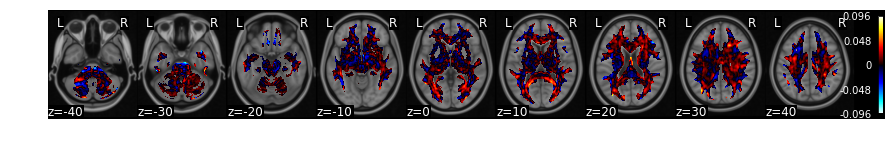

In [127]:
# split data one train/test
train = fa_data[fa_data.X['Holdout']=='train']
subject_id = train.X['SubjectID']
train.Y = train.X['Selfesteem']

test = fa_data[fa_data.X['Holdout']=='test']
test.Y = test.X['Selfesteem']

# fit model
stats_svr= train.predict(algorithm='svr',plot=True, 
                         cv_dict={'type': 'loso','subject_id':subject_id},  
                         **{'kernel':'linear'})


overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 16.19
overall CV Correlation: 0.08


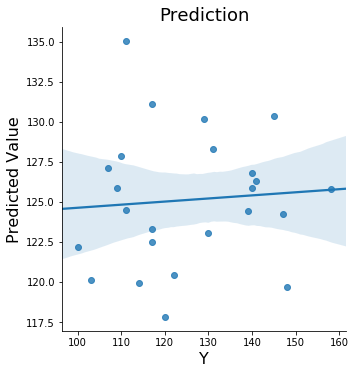

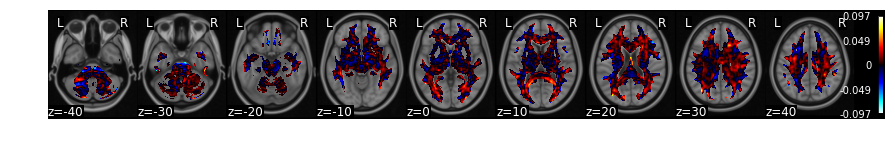

In [128]:
stats_ridge = train.predict(algorithm='ridge', plot=True, 
                            cv_dict={'type': 'loso','subject_id':subject_id}, 
                            **{'alpha':.1})


overall Root Mean Squared Error: 1.29
overall Correlation: 1.00
overall CV Root Mean Squared Error: 16.18
overall CV Correlation: 0.07


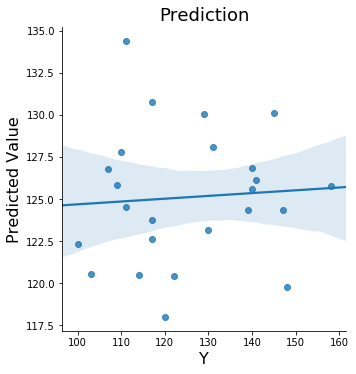

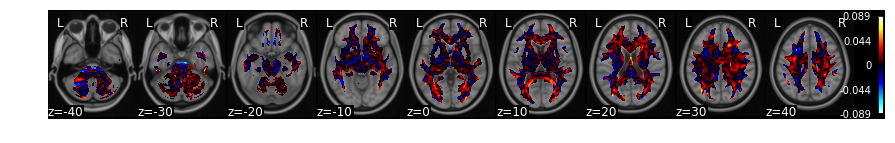

In [129]:
stats_lassopcr = train.predict(algorithm='lassopcr', 
                               cv_dict={'type': 'loso','subject_id':subject_id}, 
                                        plot=True)

In [130]:
# Save weight map brain for plotting 
stats_svr['weight_map'].write('weight_map_SVR.nii.gz')

# Apply models to testing sample

### SVR

Holdout: R = 0.388383532113, p = 0.0607232095633, R2 = 0.150841768016, RMSE =  19.0603580312
Plotting unthresholded image


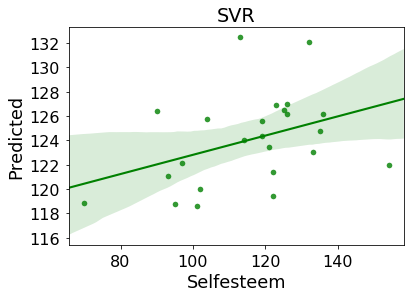

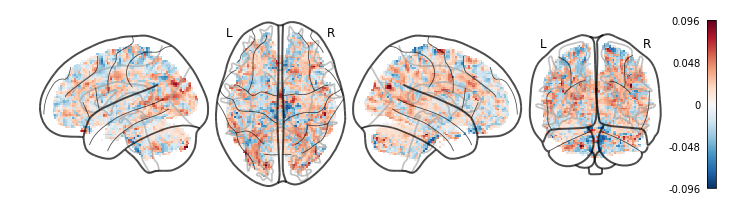

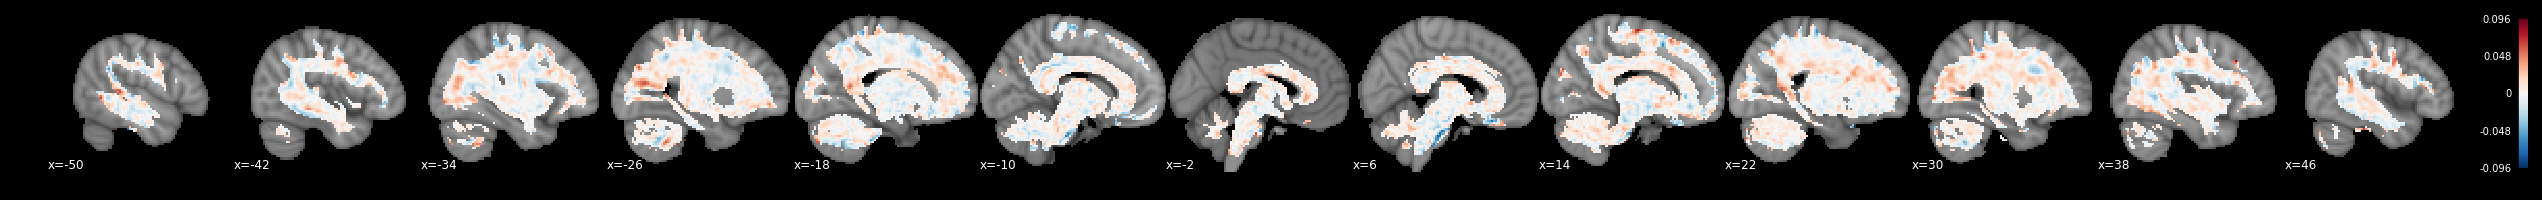

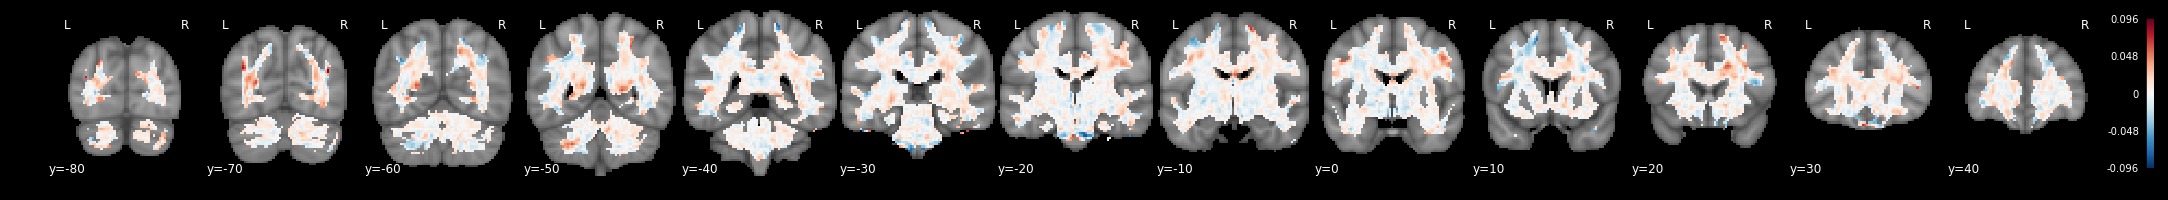

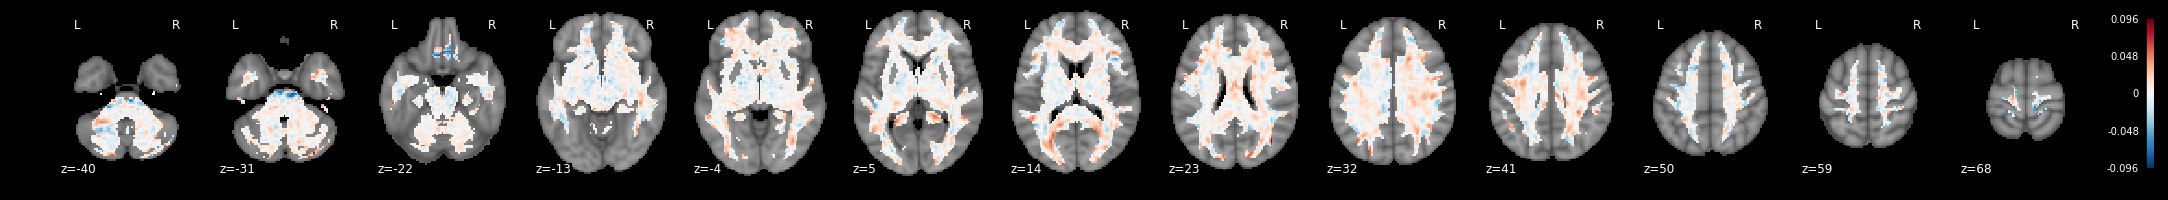

In [131]:
# apply predictions to holdout data
predicted_se_svr = test.similarity(stats_svr['weight_map'],'dot_product') + stats_svr['intercept']

data_svr = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se_svr,'Selfesteem':test.X['Selfesteem']})

# scatter plot of predicted values
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=data_svr,x='Selfesteem',y='Predicted', color='green').set_title("SVR")

# calculate fit metrics    
fit = pearsonr(data_svr.Selfesteem, data_svr.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_svr.Selfesteem, data_svr.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# plot brain
plotBrain(stats_svr['weight_map'])

### Ridge

Holdout: R = 0.388981125735, p = 0.0602933537422, R2 = 0.151306316178, RMSE =  19.0548619617
Plotting unthresholded image


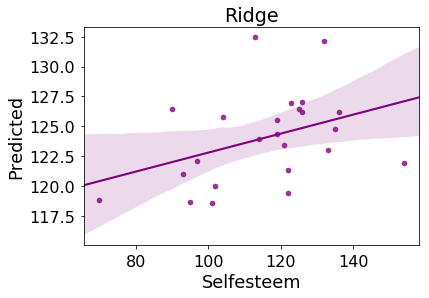

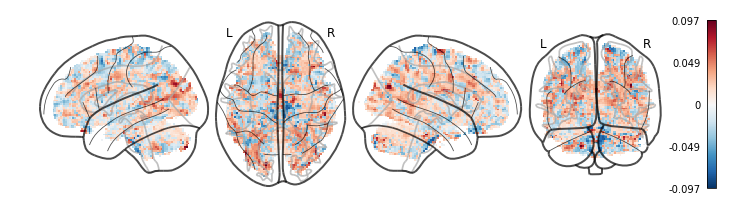

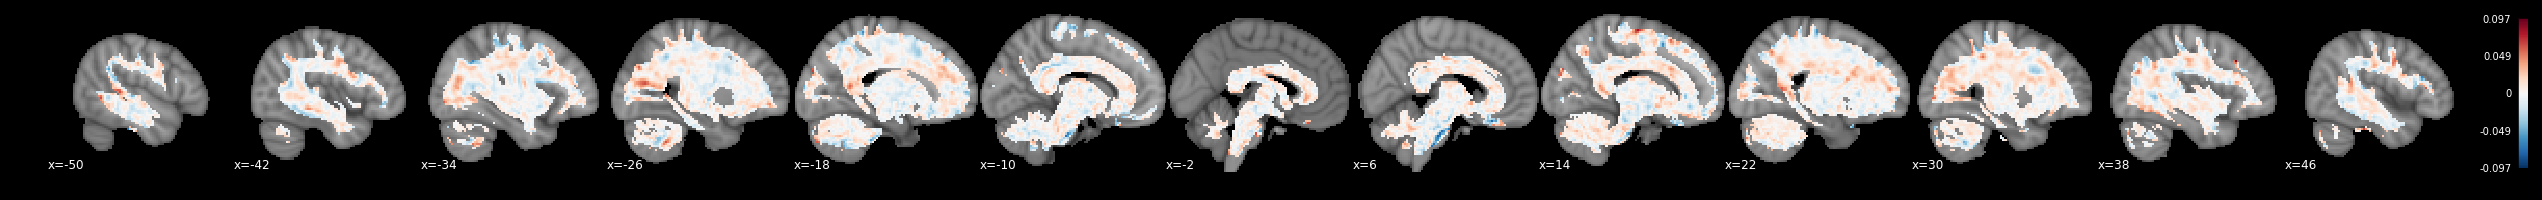

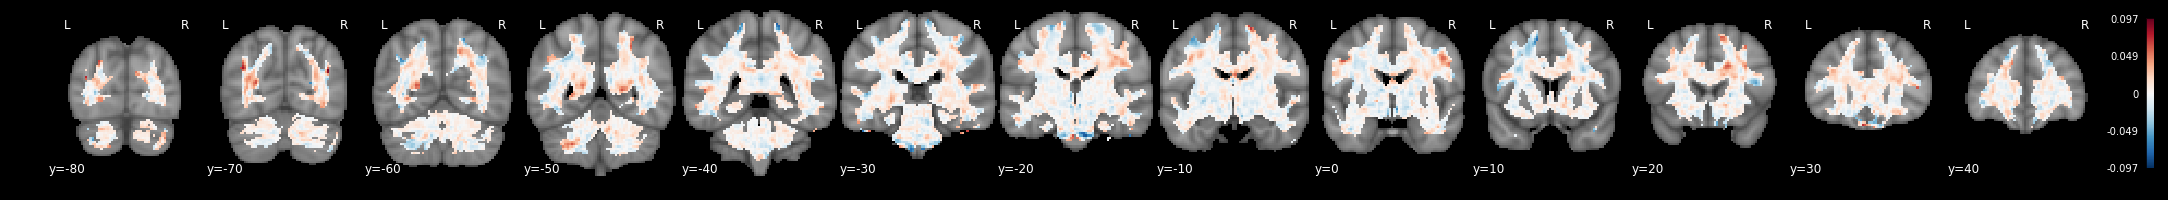

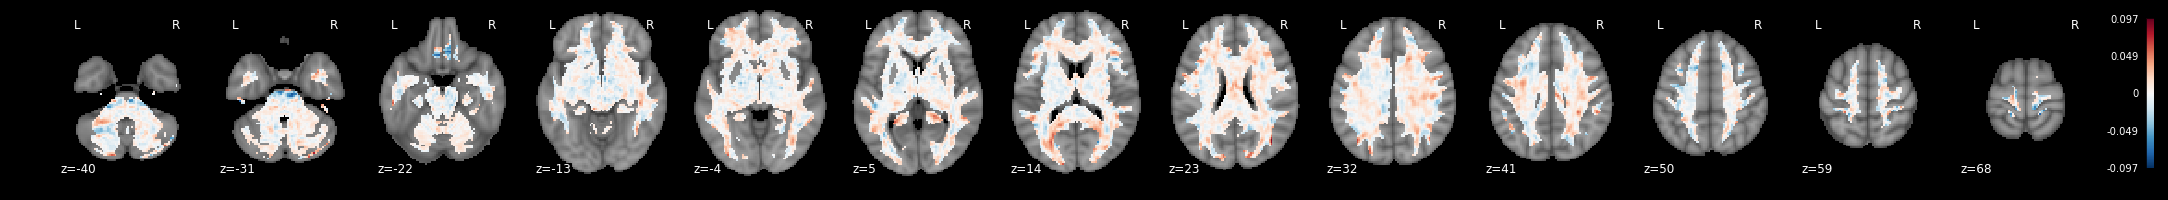

In [132]:
# apply predictions to holdout data
predicted_se_ridge = test.similarity(stats_ridge['weight_map'],'dot_product') + stats_ridge['intercept']

data_ridge = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se_ridge,'Selfesteem':test.X['Selfesteem']})

# scatter plot of predicted values
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=data_ridge,x='Selfesteem',y='Predicted', color='purple').set_title("Ridge")

# calculate fit metrics    
fit = pearsonr(data_ridge.Selfesteem, data_ridge.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_ridge.Selfesteem, data_ridge.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# plot brain
plotBrain(stats_ridge['weight_map'])

### Lasso PCR

Holdout: R = 0.395649091175, p = 0.0556544616401, R2 = 0.156538203348, RMSE =  79.9499336302
Plotting unthresholded image


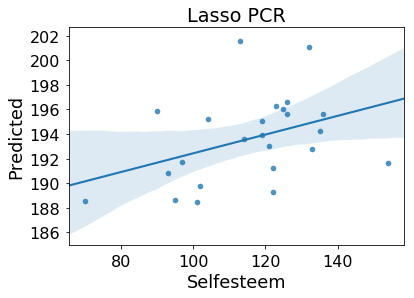

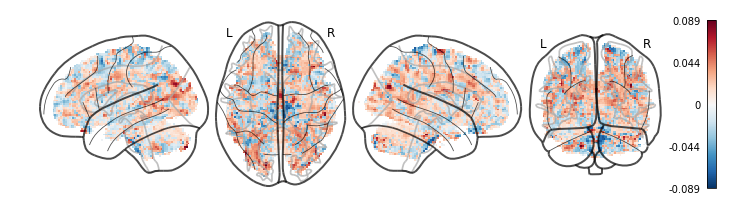

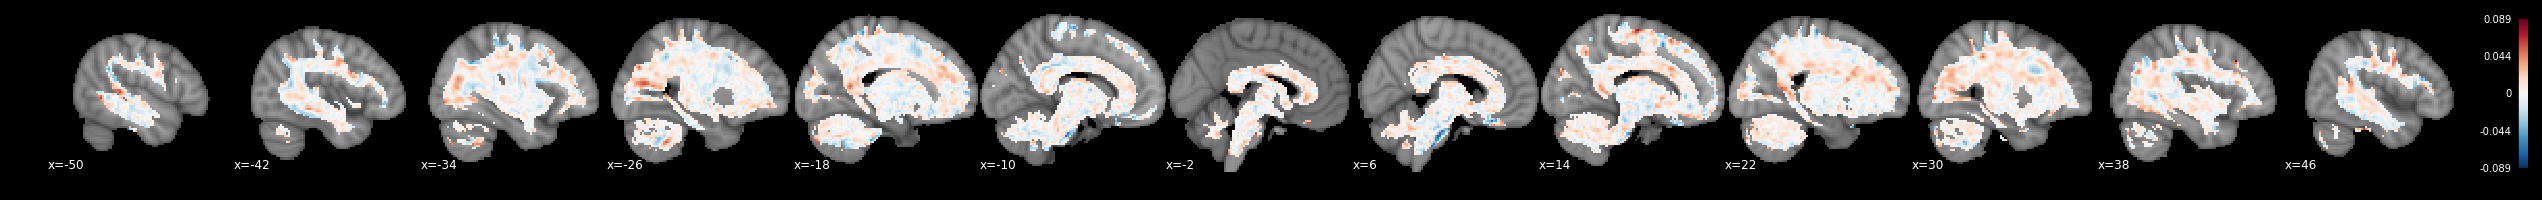

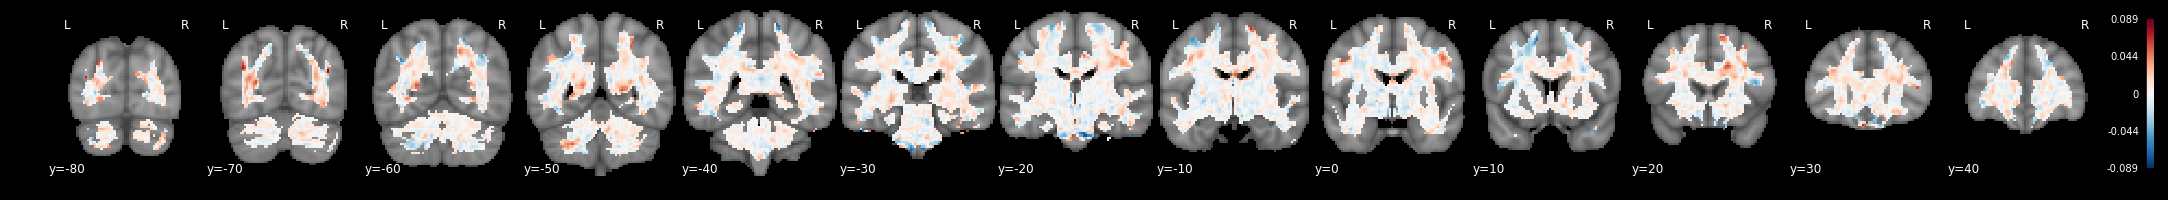

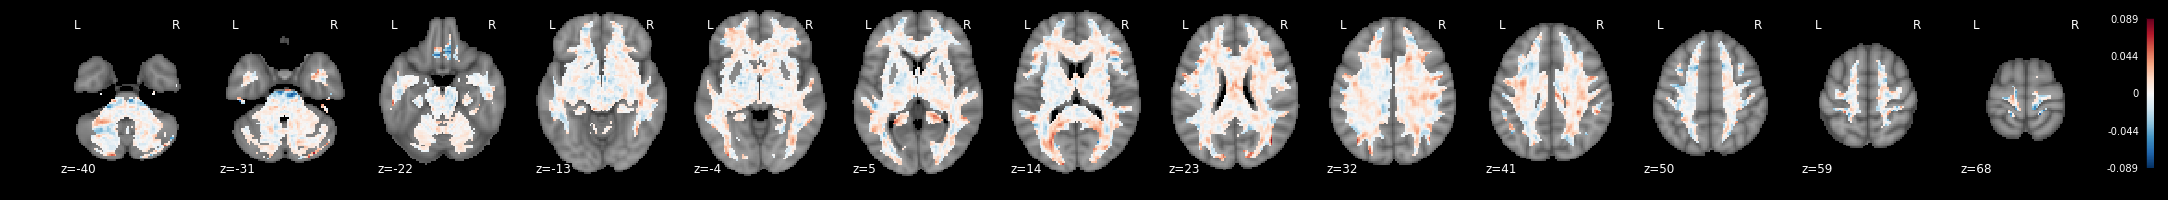

In [133]:
# apply predictions to holdout data
predicted_se_lassopcr = test.similarity(stats_lassopcr['weight_map'],'dot_product') + stats_lassopcr['intercept']

data_lassopcr = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se_lassopcr,'Selfesteem':test.X['Selfesteem']})

# scatter plot of predicted values
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=data_lassopcr,x='Selfesteem',y='Predicted').set_title("Lasso PCR")

# calculate fit metrics    
fit = pearsonr(data_lassopcr.Selfesteem, data_lassopcr.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_lassopcr.Selfesteem, data_lassopcr.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# plot brain
plotBrain(stats_lassopcr['weight_map'])

## Specificity
Here, we will use the self-esteem weight map to predict a different trait, extraversion. You can see that the same weight map does not do as well predicting extraversion (even though the two are highly correlated).

(0.77368938100315332, 9.2298253965490124e-06)

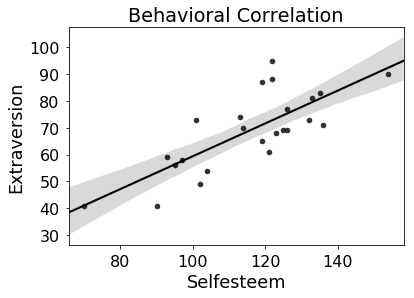

In [135]:
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=test.X,x='Selfesteem',y='Extraversion', color='black').set_title("Behavioral Correlation")

pearsonr(test.X['Selfesteem'], test.X['Extraversion'])


Holdout: R = 0.091245347112, p = 0.671542059594, R2 = 0.00832571336958, RMSE =  57.0708333209


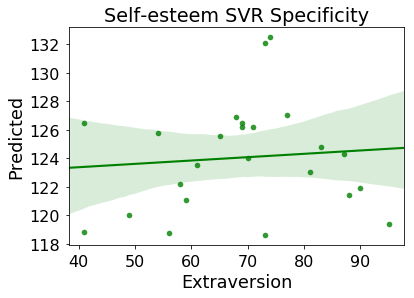

In [136]:
# apply predictions to holdout data
predicted_se_svr = test.similarity(stats_svr['weight_map'],'dot_product') + stats_svr['intercept']

data_svr = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se_svr,'Extraversion':test.X['Extraversion']})

# scatter plot of predicted values
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=data_svr,x='Extraversion',y='Predicted', color='green').set_title("Self-esteem SVR Specificity")

# calculate fit metrics    
fit = pearsonr(data_svr.Extraversion, data_svr.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_svr.Extraversion, data_svr.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


## Comparing weight maps
Weight map correlations are very high.

(0.99999556406635426, 0.0)

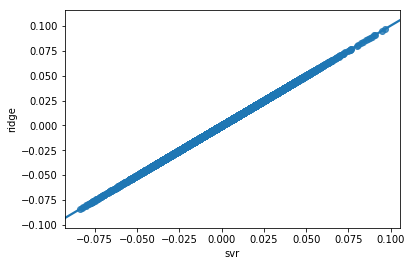

In [134]:
wm_svr = stats_svr['weight_map'].data
wm_ridge = stats_ridge['weight_map'].data
wm_lassopcr = stats_lassopcr['weight_map'].data

#wm_dat = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se,'JF_new':test.X['JF_new']})
wm_dat = pd.DataFrame(data={'svr': wm_svr, 'ridge': wm_ridge, 'lassopcr': wm_lassopcr})

sns.regplot(data=wm_dat,x='svr',y='ridge')
pearsonr(wm_dat.svr, wm_dat.ridge)

